In [8]:
import torch
from torch import nn
from vector_dataset import *
import scipy.sparse
import numpy as np
import torchsummary

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

from torch.utils.tensorboard import SummaryWriter

In [9]:
def init_zeros(m):
    if isinstance(m, nn.Conv3d):
        m.weight.data.fill_(0)

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)

class ResidualBlock(nn.Module):
    def __init__(self, depth):
        super(ResidualBlock, self).__init__()
        self.x_layer = nn.Conv3d(in_channels = depth, out_channels = depth, kernel_size = (3,3,3), padding = "same", bias = False)   # no change
        self.y_layer = nn.Conv3d(in_channels = depth, out_channels = depth, kernel_size = (3,3,3), padding = "same", bias = False)   # no change
        self.relu = nn.ReLU(inplace = True)
        
        # self.x_layer.apply(init_zeros)
        # self.y_layer.apply(init_zeros)
    
    def forward(self,x):
        residual = x.clone()
        x1 = self.relu(self.x_layer(x))
        x2 = self.y_layer(x1)
        out = self.relu(x2) + residual
        return out




class SimpleModel(nn.Module):
   
    def __init__(self, dim_x, dim_y, dim_z):
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.dim_z = dim_z
        super(SimpleModel, self).__init__()
        depth = 2
        self.conv1 = nn.Sequential(
           nn.Conv3d(in_channels = 1, out_channels = depth, kernel_size = (3,3,3), padding = "same"),
           nn.Conv3d(in_channels = depth, out_channels = depth, kernel_size = (3,3,3), padding = "same"),
           nn.ReLU(),
           nn.Conv3d(in_channels = depth, out_channels = depth, kernel_size = (3,3,3), padding = "same"),
           nn.ReLU(),
           nn.Conv3d(in_channels = depth, out_channels = depth, kernel_size = (3,3,3), padding = "same"),
           nn.ReLU(),
           nn.Conv3d(in_channels = depth, out_channels = depth, kernel_size = (3,3,3), padding = "same"),
           nn.ReLU(),
           nn.Conv3d(in_channels = depth, out_channels = depth, kernel_size = (3,3,3), padding = "same"),
           nn.ReLU(),
           nn.Conv3d(in_channels = depth, out_channels = depth, kernel_size = (3,3,3), padding = "same"),
           nn.ReLU(),
           nn.Conv3d(in_channels = depth, out_channels = depth, kernel_size = (3,3,3), padding = "same"),
           nn.ReLU())
        

    

        self.fc_layer = nn.Linear(in_features = 4, out_features = 1)
        self.out_layer = nn.Conv3d(in_channels = 4, out_channels = 1, kernel_size = (3,3,3), padding = "same")

        self.conv1.apply(init_weights)
        self.fc_layer.apply(init_weights)
        
    # feed through the convolutional layers
    def forward(self, x):
        x = self.conv1(x)
        x = x.permute(0, 4, 2, 3, 1) 
        x = self.fc_layer(x)
        x = x.permute(0, 4, 2, 3, 1) 
        x = x.reshape(x.size(0), 1, x.size(2) * x.size(3) * x.size(4))
        # x = self.fc_layer(x)
        # x6 = x5.view(-1, 1, x5.size(1) * x5.size(2) * x5.size(3) * x5.size(4))
        # x7 = self.fc_layer(x6)
        return x


class CNN(nn.Module):

    

    def __init__(self, dim_x, dim_y, dim_z):
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.dim_z = dim_z
        super(CNN, self).__init__()
        self.depth = 16
        self.conv1 = nn.Sequential(
           nn.Conv3d(in_channels = 1, out_channels = self.depth, kernel_size = (3,3,3), padding = "same"),
           ResidualBlock(self.depth),
           ResidualBlock(self.depth))
        

        self.pool_layer = nn.AvgPool3d(kernel_size = (2,2,2), stride=(2,2,2))


        self.conv2 = nn.Sequential(
           ResidualBlock(self.depth),
           ResidualBlock(self.depth),
           ResidualBlock(self.depth),
           ResidualBlock(self.depth),
           ResidualBlock(self.depth))


        self.upsample_layer = nn.Upsample(scale_factor = (2,2,2))
        
        self.conv3 = nn.Sequential(
           ResidualBlock(self.depth),
           ResidualBlock(self.depth),
           ResidualBlock(self.depth))

        self.fc_layer = nn.Linear(in_features = self.depth, out_features = 1)
        self.out_layer = nn.Conv3d(in_channels = self.depth, out_channels = 1, kernel_size = (1, 1, 1), padding = "same")

            
    # feed through the convolutional layers
    def forward(self, x):
        xr = self.conv1(x).clone()
        x = self.pool_layer(xr.clone())
        x = self.conv2(x)
        x = self.upsample_layer(x) + xr
        x = self.conv3(x)
        x = self.out_layer(x)
    
        return x

In [12]:
dataset = VectorDataset()
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.95, 0.05]) 
train_dataloader = DataLoader(train_dataset, batch_size=1, num_workers=4, shuffle = True)

In [17]:
X = next(iter(train_dataloader))
X = X.view((1, 1, dim_x, dim_y, dim_z))

In [25]:
dim_x, dim_y, dim_z = 8, 8, 8
DEVICE = "cuda"


models_dir = f"./models/"
model_fn = f"{dim_x}_{dim_y}_{dim_z}_grid_state_16_mod.pth"
model = CNN(dim_x, dim_y, dim_z).to(DEVICE, dtype = torch.float64)
model.load_state_dict(torch.load(models_dir + model_fn, weights_only=False))

writer = SummaryWriter("torchlogs/")
writer.add_graph(model, X.to(DEVICE, dtype = torch.float64))
writer.close()

In [ ]:

models_dir = f"./models/"
model_fn = f"{dim_x}_{dim_y}_{dim_z}_grid_state_16_mod.pth"
model = CNN(dim_x, dim_y, dim_z).to(DEVICE)
model.load_state_dict(torch.load(models_dir + model_fn))

input_names = ["Residual"]
output_names = ["New Search Direction"]

torch.onnx.export()


In [21]:
2 ** 8

256

In [86]:
x = torch.tensor([[1., 2.], 
                  [4., 5.], 
                 ]) 
x = x.view(1,1,2,2) 

upsample_x = torch.nn.Upsample(scale_factor = (1,2))(x)
upsample_x

tensor([[[[1., 1., 2., 2.],
          [4., 4., 5., 5.]]]])

In [6]:


#import the necessary library 
import torch 
  
# define a tensor and view as a 3D tensor 
x = torch.tensor([1., 2.]) 
X = x.view(1,1,2) 
print("Input Tensor Shape:",X.size()) 
print("Input Tensor:",X) 
  
# Upsample with scale_factor 2 and mode = nearest 
upsample1 = torch.nn.Upsample(scale_factor=2) 
output1 = upsample1(X) 
print(upsample1,'-->>', output1) 
  
# # Upsample with scale_factor 3 and mode = nearest 
upsample2 = torch.nn.Upsample(scale_factor=3) 
output2 = upsample2(X) 
print(upsample2,'-->>', output2) 
  
# Upsample with scale_factor 2 and mode = linear 
upsample3 = torch.nn.Upsample(scale_factor=2, mode='linear') 
output3 = upsample3(X) 
print(upsample3,' -->>', output3)


Input Tensor Shape: torch.Size([1, 1, 2])
Input Tensor: tensor([[[1., 2.]]])
Upsample(scale_factor=2.0, mode='nearest') -->> tensor([[[1., 1., 2., 2.]]])
Upsample(scale_factor=3.0, mode='nearest') -->> tensor([[[1., 1., 1., 2., 2., 2.]]])
Upsample(scale_factor=2.0, mode='linear')  -->> tensor([[[1.0000, 1.2500, 1.7500, 2.0000]]])


In [87]:
2 * np.log2(9) + np.log2(9/7)

6.702420082269333

In [88]:
dataset = VectorDataset()
train, test = torch.utils.data.random_split(dataset, [0.7, 0.3], torch.Generator().manual_seed(999)) 
print(type(train))

<class 'torch.utils.data.dataset.Subset'>


In [89]:
A = scipy.sparse.load_npz("A_matrix.npz")
A = torch.sparse_coo_tensor(np.array([A.row, A.col]), A.data).to_sparse_csr()

/tmp/ipykernel_20826/3521309801.py:2: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  A = torch.sparse_coo_tensor(np.array([A.row, A.col]), A.data).to_sparse_csr()


In [ ]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2], torch.Generator().manual_seed(999)) 
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, num_workers=4, shuffle = True)


tensor(1.0000, dtype=torch.float64)

In [23]:
v = next(iter(train_dataloader))
v.shape

torch.Size([1, 1, 4096])

In [24]:
torch.mv(A, v.squeeze())

tensor([ 0.0574, -0.1615,  0.0173,  ..., -0.0199, -0.0464, -0.0061],
       dtype=torch.float64)

In [ ]:
import scipy.linalg
import random 

random.seed(90977)

def cgd(A:scipy.sparse.csr_matrix, b:np.ndarray, tol = 1e-16):
    
    
    x = b.copy()
    d = b - A.dot(x)
    res = b - A.dot(x)
    res_norm = np.linalg.norm(res)

    res_arr = [res_norm]
    count = 0
    while(res_norm > tol):
        print(res_arr[-1])
        res_old = res.copy()
        alpha = res.dot(res)/ d.dot((A.dot(d)))
        x = x + alpha * d
        res = b - A.dot(d)
        beta = res.dot(res)/(res_old.dot(res_old))
        d = res + beta * d

        res_norm = scipy.linalg.norm(res) 
        res_arr = res_arr + [res_norm]
        count += 1
    
    print(f"Finished in {count} iterations")
    return res_arr, x


def neural_cgd(A:scipy.sparse.csr_matrix, b:np.ndarray, tol = 1e-16):
    pass

def pcgd(A:scipy.sparse.csr_matrix, iM:scipy.sparse.csr_matrix,b:np.ndarray,tol = 1e-10, max_it = 3e5):
    # solve P^T A P (iPx) = P^T b
    # M^-1 = P * P^T
    
    x = np.zeros(len(b))
    res = b.copy()
    res_ = iM.dot(res) # stores iM * res
    res_old = res.copy()
    res_old_ = res_.copy() # stores iM * res_old
    d = res_.copy()

    count = 0
    res_norm = np.linalg.norm(res_)
    res_arr = [res_norm]


    while(res_norm > tol and count < max_it):
        # print(res_arr[-1])
        alpha = res.dot(res_)/d.dot(A.dot(d))
        x = x + alpha * d
        
        res_old = res.copy()
        res_old_ = res_.copy()
        res = res_old - alpha * A.dot(d)
        res_ = iM.dot(res)

        beta = res.dot(res_) / res_old.dot(res_old_)
        d_old = d.copy()
        d = res_ + beta * d
        print(res_norm)
        res_norm = scipy.linalg.norm(res)
        res_arr = res_arr + [res_norm]
        
        count+=1

    print(f"Finished in {count} iterations")
    return res_arr, x

def icholesky(a):
    n = a.shape[0]
    for k in range(n): 
        a[k,k] = np.sqrt(a[k,k])
        i_, = a[k+1:,k].nonzero() 
        if len(i_) > 0:
            i_= i_ + (k+1)
            a[i_,k] = a[i_,k]/a[k,k]
        for j in i_: 
            i2_, = a[j:n,j].nonzero()
            if len(i2_) > 0:
                i2_ = i2_ + j
                a[i2_,j]  = a[i2_,j] - a[i2_,k]*a[j,k]   
        
    return a


def pcgd_backsolve(A:scipy.sparse.csr_matrix, R:scipy.sparse.csr_matrix,b:np.ndarray,tol = 1e-10, max_it = 3e5):
    # solve P^T A P (iPx) = P^T b
    # R^-1 = P * P^T
    
    x = np.zeros(len(b))
    r = b.copy()
    z = scipy.sparse.linalg.spsolve_triangular(R, r, lower = False) # stores iM * res
    z = scipy.sparse.linalg.spsolve_triangular(R, z, lower = True)
    r_old = r.copy()
    z_old = z.copy() # stores iM * res_old
    d = z.copy()

    count = 0
    res_norm = np.linalg.norm(r)
    res_arr = [res_norm]

    while(res_norm > tol and count < max_it):
        # print(res_arr[-1])
        alpha = r.dot(z)/d.dot(A.dot(d))
        x = x + alpha * d
        
        r_old = r.copy()
        z_old = z.copy()
        r = r_old - alpha * A.dot(d) # A.dot gives a matrix-vector product in this case
        # R backsolve
        z = scipy.sparse.linalg.spsolve_triangular(R, r, lower = False) 
        z = scipy.sparse.linalg.spsolve_triangular(R, z, lower = True)

        beta = r.dot(z) / r_old.dot(z_old)
        d = z + beta * d
        print(res_norm)
        res_norm = scipy.linalg.norm(r)
        res_arr = res_arr + [res_norm]
        
        count+=1

    print(f"Finished in {count} iterations")
    return res_arr, x


    

matrix_fn = "A_matrix_4_4_32"
# generate A and b
A = scipy.sparse.load_npz(f"{matrix_fn}.npz").tocsr()
training_vectors = np.load(f"{matrix_fn}_training.npy")
idx = random.randint(0,training_vectors.shape[0] - 1)
b = training_vectors[idx,:]


# generate jacobi preconditioner
diag_A = np.sqrt(A.diagonal())
diag_A = scipy.sparse.diags(diag_A).tocsc()
iM = diag_A.copy()
iM.data = 1/diag_A.data
# generate IC preconditioner

# M = np.tril(icholesky(A.toarray()))
# M = scipy.sparse.csr_matrix(M)

res_arr, x = pcgd_backsolve(A,b = b, R = diag_A, tol = 1e-8)
print(np.linalg.norm(b - A @ x)) 
# res_arr, x = cgd(pA, b.copy())

# # condition A
# diag_A = A.diagonal()
# diag_A = scipy.sparse.diags(diag_A)
# idiag_A = diag_A.copy()
# idiag_A.data = 1/idiag_A.data

# pA = diag_A.multiply(A.multiply(idiag_A))



/tmp/ipykernel_6696/4210752795.py:97: SparseEfficiencyWarning: CSR matrix format is required. Converting to CSR matrix.
  z = scipy.sparse.linalg.spsolve_triangular(R, r, lower = False) # stores iM * res
/tmp/ipykernel_6696/4210752795.py:98: SparseEfficiencyWarning: CSR matrix format is required. Converting to CSR matrix.
  z = scipy.sparse.linalg.spsolve_triangular(R, z, lower = True)
/tmp/ipykernel_6696/4210752795.py:116: SparseEfficiencyWarning: CSR matrix format is required. Converting to CSR matrix.
  z = scipy.sparse.linalg.spsolve_triangular(R, r, lower = False)
/tmp/ipykernel_6696/4210752795.py:117: SparseEfficiencyWarning: CSR matrix format is required. Converting to CSR matrix.
  z = scipy.sparse.linalg.spsolve_triangular(R, z, lower = True)


0.9999999999999999
0.4322792576474336
0.31784042204030477
0.2213000214533968
0.1765828862994721
0.11536377824396059
0.09046656923900266
0.07308811262479922
0.06789777109103613
0.06685455624447763
0.06478468234251201
0.05660423611654443
0.03997037892936046
0.03145213706030119
0.03061408026865957
0.03343089191878588
0.034512423153779385
0.033365414680004465
0.032462422611333724
0.03190029218766039
0.030537073300393687
0.03253716862915632
0.03633477468635082
0.03957843135169665
0.04026640664781923
0.036511124594164265
0.03263090853499289
0.03018931697235288
0.032270313396693596
0.037693695117320444
0.037117108910798814
0.033797921057595326
0.0300172280346116
0.02273599895747647
0.018195828898683594
0.01611194234968316
0.014296294144472975
0.012595601675322471
0.010924740147586678
0.008413738393726077
0.00572038136496717
0.0036385656637851404
0.0025745901397117685
0.0016103051985806808
0.0010819760889160229
0.0008553859280665473
0.0007649369366609124
0.0007601680449791703
0.000796468004958

In [11]:
G = np.array([[1, 1],[0, -1]])
g = np.array([1, 2])
print(G.dot(g))

[ 3 -2]


In [48]:
print(np.linalg.cond(iM.multiply(A).todense(), 2))

1.0


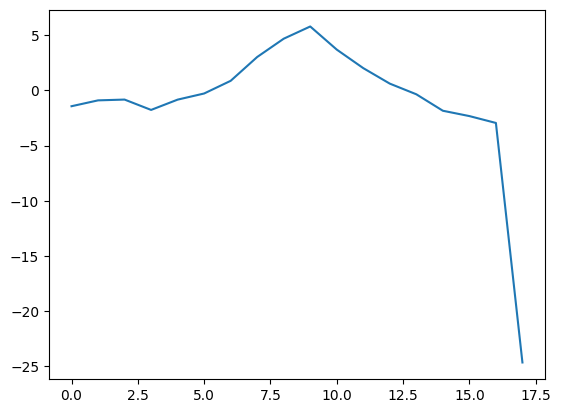

In [22]:
import matplotlib.pyplot as plt
plt.plot(np.log(res_arr))

In [66]:
M_inverse=scipy.sparse.linalg.spilu(A)
M2=scipy.sparse.linalg.LinearOperator(A.shape,M_inverse.solve)
sol=scipy.sparse.linalg.cg(A,b,M = M2)

sol = scipy.sparse.linalg.cg(A = A, b = b, rtol = 1e-16, maxiter = 50000)
# sol = scipy.sparse.linalg.gmres(A = A, b = b, x0 = b, rtol = 1e-16, M = diag_A)

/tmp/ipykernel_17891/2776222686.py:1: SparseEfficiencyWarning: spilu converted its input to CSC format
  M_inverse=scipy.sparse.linalg.spilu(A)


In [63]:
x = scipy.linalg.solve(iM.toarray() @ A.toarray(), iM.toarray()  @ b)
print(np.linalg.norm(( b - A.dot(x))))


0.055266941087814464


/tmp/ipykernel_17891/3454406662.py:1: LinAlgWarning: Ill-conditioned matrix (rcond=3.76928e-18): result may not be accurate.
  x = scipy.linalg.solve(iM.toarray() @ A.toarray(), iM.toarray()  @ b)


In [65]:
print(sol)
x = sol[0]

(array([9.94056146e+13, 9.94056146e+13, 9.94056146e+13, 9.94056146e+13,
       9.94056146e+13, 9.94056146e+13, 9.94056146e+13, 9.94056146e+13,
       9.94056146e+13, 9.94056146e+13, 9.94056146e+13, 9.94056146e+13,
       9.94056146e+13, 9.94056146e+13, 9.94056146e+13, 9.94056146e+13,
       9.94056146e+13, 9.94056146e+13, 9.94056146e+13, 9.94056146e+13,
       9.94056146e+13, 9.94056146e+13, 9.94056146e+13, 9.94056146e+13,
       9.94056146e+13, 9.94056146e+13, 9.94056146e+13]), 50000)


In [58]:
print(np.linalg.norm(( b - A.dot(x))))
print(b.dot(A * b))

35.23964850847612
0.9565135516648643


In [74]:
lx,ly,lz = 8, 8, 8

rho = 1
dt = 1
dx = 1
A = None
sA = None


# helpers
def grid_to_row_col(i:int,j:int,k:int) -> int:
    return i + lx * j + lx * ly * k
def is_boundary(i, j, k): # check if cell belongs to the boundary
    if(i == -1 or i == lx or j == -1 or j == ly or k == -1 or k == lz):
        return True
    
    return False


# initialize A matrix      
A = np.zeros((lx * ly * lz, lx * ly * lz))

# iterate over all points in 3d grid
for k in range(0, lz):
    for j in range(0, ly):
        for i in range(0, lx):
            row = grid_to_row_col(i, j, k)
            col = row
            A[row, col] = 6
            
            # impose neumann boundary conditions
            if(not is_boundary(i + 1, j, k)):
                A[row, grid_to_row_col(i + 1, j, k)] = -1
            else:
                A[row,col] -= 1

            if(not is_boundary(i - 1, j, k)):
                A[row, grid_to_row_col(i - 1, j, k)] = -1
            else:
                A[row,col] -= 1

            if(not is_boundary(i, j + 1, k)):
                A[row, grid_to_row_col(i, j + 1, k)] = -1
            else:
                A[row,col] -= 1

            if(not is_boundary(i, j - 1, k)):
                A[row, grid_to_row_col(i, j - 1, k)] = -1
            else:
                A[row,col] -= 1
            
            if(not is_boundary(i, j, k + 1)):
                A[row, grid_to_row_col(i, j, k + 1)] = -1
            else:
                A[row,col] -= 1
            
            if(not is_boundary(i, j, k - 1)):
                A[row, grid_to_row_col(i, j, k - 1)] = -1
            else:
                A[row,col] -= 1


# # iterate over all points in 3d grid
# for k in range(0, lz):
#     for j in range(0, ly):
#         for i in range(0, lx):
#             row = grid_to_row_col(i, j, k)
#             col = row
#             A[row, col] = 6
            
#             # impose neumann boundary conditions
#             if(not is_boundary(i + 1, j, k)):
#                 A[row, grid_to_row_col(i + 1, j, k)] = -1
#             else:
#                 A[row,grid_to_row_col(i - 1, j, k)] = -2

#             if(not is_boundary(i - 1, j, k)):
#                 A[row, grid_to_row_col(i - 1, j, k)] = -1
#             else:
#                 A[row,grid_to_row_col(i + 1, j, k)] = -2

#             if(not is_boundary(i, j + 1, k)):
#                 A[row, grid_to_row_col(i, j + 1, k)] = -1
#             else:
#                 A[row, grid_to_row_col(i, j - 1, k)] = -2

#             if(not is_boundary(i, j - 1, k)):
#                 A[row, grid_to_row_col(i, j - 1, k)] = -1
#             else:
#                 A[row, grid_to_row_col(i, j + 1, k)] = -2

#             if(not is_boundary(i, j, k + 1)):
#                 A[row, grid_to_row_col(i, j, k + 1)] = -1
#             else:
#                 A[row, grid_to_row_col(i, j, k - 1)] = -2
            
#             if(not is_boundary(i, j, k - 1)):
#                 A[row, grid_to_row_col(i, j, k - 1)] = -1
#             else:
#                 A[row, grid_to_row_col(i, j, k + 1)] = -2




Text(0.5, 1.0, 'Eigenvalues of A')

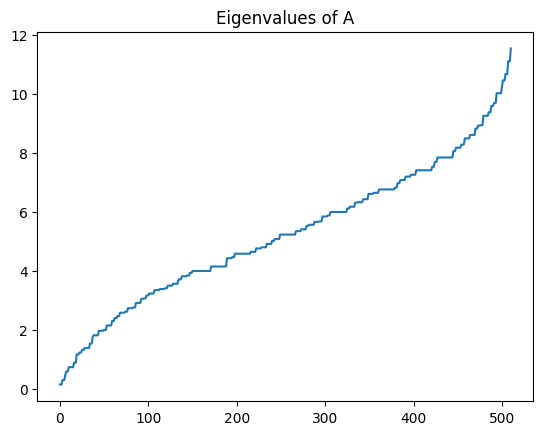

In [77]:
import scipy.linalg
import matplotlib.pyplot as plt
Ae, Av = map(np.real, scipy.linalg.eig(A))
# reorder eigen values 
ind = np.argsort(Ae)
nullspace = Av[:, 0]/np.linalg.norm(Av[:, 0])
Ae, Av = Ae[ind], Av.T[ind, :] # the rows are now eigenvectors
Ae, Av = Ae[1:], Av[1:]
Av = Av - np.outer((Av @ nullspace), nullspace)

plt.plot(Ae)
plt.title("Eigenvalues of A")

In [78]:
import scipy.stats

num_vectors = 20000 # training vectors
theta = 65
m = 8 * 8 * 8 - 1

coeff_set = np.zeros((num_vectors, m))
for i in range(num_vectors):
   
    cutoff = int(m * 0.5 + theta)
    loc = 0
    scale = 1

    x_large = 9 * scipy.stats.norm.rvs(loc, scale, cutoff) 
    x = scipy.stats.norm.rvs(loc, scale, int(m - cutoff)) 

    coeff = np.concatenate((x_large, x))
    coeff_set[i, :] = coeff    
    if(i % 100 == 0):
        print(f"{i} vectors generated")

0 vectors generated
100 vectors generated
200 vectors generated
300 vectors generated
400 vectors generated
500 vectors generated
600 vectors generated
700 vectors generated
800 vectors generated
900 vectors generated
1000 vectors generated
1100 vectors generated
1200 vectors generated
1300 vectors generated
1400 vectors generated
1500 vectors generated
1600 vectors generated
1700 vectors generated
1800 vectors generated
1900 vectors generated
2000 vectors generated
2100 vectors generated
2200 vectors generated
2300 vectors generated
2400 vectors generated
2500 vectors generated
2600 vectors generated
2700 vectors generated
2800 vectors generated
2900 vectors generated
3000 vectors generated
3100 vectors generated
3200 vectors generated
3300 vectors generated
3400 vectors generated
3500 vectors generated
3600 vectors generated
3700 vectors generated
3800 vectors generated
3900 vectors generated
4000 vectors generated
4100 vectors generated
4200 vectors generated
4300 vectors generated


In [79]:
import scipy.linalg


training_vectors = coeff_set @ Av  # generate training vectors from coefficients, shape [num_samples, dim(x)]

# normalize training vectors
training_vectors = np.diag(1 / scipy.linalg.norm(training_vectors, ord = 2, axis = 1)) @ training_vectors


In [81]:
def incomplete_cholesky(A):
    E = np.zeros(A.shape)
    n = A.shape[0]

    for k in range(n - 1):
        E[k, k] = np.sqrt(A[k,k])
        for j in range(k + 1, n):
            E[j, k] = A[k, j]/E[k, k]
        

        for i in range(k + 1, n):
            for j in range(i, n):
                if(A[i, j] != 0):
                    A[i, j] = A[i, j] - E[k, i] * E[k, j]
                
    E[-1, -1] = np.sqrt(A[-1, -1])    
    return E

# E = incomplete_cholesky(A.copy())
# E = np.tril(icholesky(A.copy()))


In [82]:
sA = scipy.sparse.csr_matrix(A)
idx = random.randint(0,training_vectors.shape[0] - 1) + 16
b = training_vectors[idx,:]

# generate jacobi conditioner
diag_A = sA.diagonal()
diag_A = scipy.sparse.diags(diag_A)
iM = diag_A.copy()
iM.data = 1/diag_A.data

# generate IC preconditioner
M = np.tril(incomplete_cholesky(sA.toarray()))
M = scipy.sparse.csr_matrix(M)
res_arr, x = cgd(A, b = b)


# res_arr, x = pcgd(sA, iM, b, tol=1e-16)

3.4015804967471515
18.767134675210922
442.46838029031613
243053.03260814917
73338029814.79736
6.677065363542585e+21
5.534755055430229e+43
3.8029793001074102e+87
1.7954572678618288e+175


ValueError: array must not contain infs or NaNs

In [11]:
A.shape

(216, 216)

6.456672944167816e-15


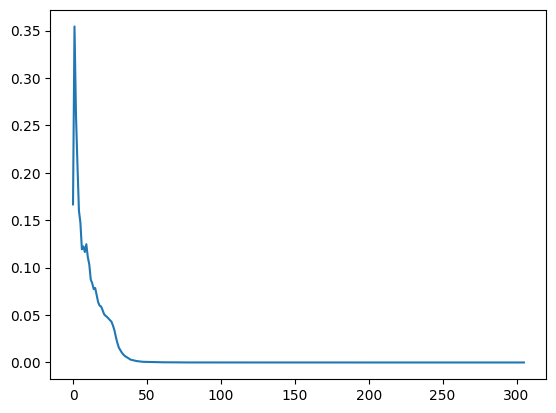

In [160]:
print(np.linalg.norm((b - sA.dot(x))))
plt.plot(res_arr)

In [170]:
sol = scipy.sparse.linalg.cg(A = sA, b = b, rtol = 1e-16, M = iM)

In [ ]:
print(b - A.dot(sol[0]))

6.1554036926363636e-15


## Model Evaluation

In [175]:
import torch

In [176]:
models_dir = f"./models/"
model_fn = "16_3_grid.pth"
model = torch.load(models_dir + model_fn)

/tmp/ipykernel_24378/1717693318.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(models_dir + model_fn)


AttributeError: Can't get attribute 'CNN' on <module '__main__'>

In [6]:
import numpy as np


a = np.sum(np.square([4, 3, 15, 12, 4, 5, 11]))
s = np.sum(np.square([108, 139, 135, 244, 172, 173, 56, 99]))

np.sqrt(s/a)

18.05248144524556

In [2]:
import torch.nn
import torchsummary

models_dir = f"./models/"
model_fn = "8_8_8_grid_state_mod.pth"
model_state = torch.load(models_dir + model_fn)

print(model_state.keys())

odict_keys(['conv1.0.weight', 'conv1.0.bias', 'conv1.1.x_layer.weight', 'conv1.1.x_layer.bias', 'conv1.1.y_layer.weight', 'conv1.1.y_layer.bias', 'conv1.2.x_layer.weight', 'conv1.2.x_layer.bias', 'conv1.2.y_layer.weight', 'conv1.2.y_layer.bias', 'conv2.0.x_layer.weight', 'conv2.0.x_layer.bias', 'conv2.0.y_layer.weight', 'conv2.0.y_layer.bias', 'conv2.1.x_layer.weight', 'conv2.1.x_layer.bias', 'conv2.1.y_layer.weight', 'conv2.1.y_layer.bias', 'conv2.2.x_layer.weight', 'conv2.2.x_layer.bias', 'conv2.2.y_layer.weight', 'conv2.2.y_layer.bias', 'conv3.0.x_layer.weight', 'conv3.0.x_layer.bias', 'conv3.0.y_layer.weight', 'conv3.0.y_layer.bias', 'conv3.1.x_layer.weight', 'conv3.1.x_layer.bias', 'conv3.1.y_layer.weight', 'conv3.1.y_layer.bias', 'conv3.2.x_layer.weight', 'conv3.2.x_layer.bias', 'conv3.2.y_layer.weight', 'conv3.2.y_layer.bias', 'fc_layer.weight', 'fc_layer.bias', 'out_layer.weight', 'out_layer.bias'])


/tmp/ipykernel_118712/557463955.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state = torch.load(models_dir + model_fn)
